In [ ]:
!pip install transformers datasets tqdm openpyxl -q

The four Python packages are installed in this line using pip. It loads model with transformers, datasets with datasets, tqdm with progress bars, and openpyxl with working with Excel files. It is used when creating a machine learning environment. Simplicity and goal are among the strengths. The no version pinning and no error handling are also weaknesses and negatively affect reproducibility.

In [ ]:
import os
import re
import random
import time
import numpy as np
import pandas as pd
import zipfile


from tqdm.auto import tqdm

import torch
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
)

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    set_seed,
)

import matplotlib.pyplot as plt

It prepares complete NLP workflow by loading system modules, data manipulation tools, progress bar, PyTorch, scikit metrics, transformers and plotting tools and you create a text classification pipeline with training, performance tracking, and analyzing the results for interpretation; its organization remains simple and straight forward and each import is assigned a specific purpose, and its logic organizes similar tools to handle data, build models, and score them. Such strengths are modular setup and purposeful intent. Drawingbacks are that it has no lazy loading and has a huge dependency footprint that causes slow startup.

In [ ]:
IN_COLAB = False
try:
    import google.colab
    IN_COLAB = True
    from google.colab import files
    print("Running in Google Colab ")
except ImportError:
    print("Not running in Colab (local/Jupyter environment).")

Running in Google Colab 


Verifies your online environment attempting to "import colab" before main, sets a flag, and does a print of the new status message and its design makes use of simple try except flow to identify Colab usage and load the files utilities when present otherwise logic is simple and the program takes into consideration the environment. Simple detection and clean flow are among the strengths. Such weak points as the lack of a fallback for partial Colab arrangement and lack of logging other than prints can be identified.

In [ ]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
set_seed(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


Python, NumPy, PyTorch CPU, PyTorch GPU, and transformers are fixed to a particular seed at this block, and then a CUDA device, should it exist, is selected, and the logic attempts to get your training runs to remain deterministic, includes seed coverage, and seed selection, and weaknesses include non-deterministic cuDNN settings default, and no warning is provided when a device is nonexistent.

In [ ]:
MODEL_DIR   = "final_bert_phishing"
TEST_FILE   = "phishing_emails_test.csv"

MAX_LEN     = 256
BATCH_SIZE  = 16

print("\nReproducibility / Test Config")
print(f"MODEL_DIR   = {MODEL_DIR}")
print(f"TEST_FILE   = {TEST_FILE}")
print(f"MAX_LEN     = {MAX_LEN}")
print(f"BATCH_SIZE  = {BATCH_SIZE}")


Reproducibility / Test Config
MODEL_DIR   = final_bert_phishing
TEST_FILE   = phishing_emails_test.csv
MAX_LEN     = 256
BATCH_SIZE  = 16


This block is used to configure values of the model loading and testing, which are printed to allow easy inspection and simple variable assignments are used to maintain consistency of your workflow; the logic sets directory paths, file names, and core hyperparameters, such as the number of tokens and the size of a batch. Clearly structured and easy to edit are some of the strengths. Hard-coded paths and lack of file existence validation is considered a weakness.

In [ ]:
if not os.path.exists(MODEL_DIR):
    print(f"Model directory '{MODEL_DIR}' not found.")

    if IN_COLAB:
        from google.colab import files

        print("\n Please upload your model ZIP (e.g. final_bert_phishing.zip)")
        uploaded = files.upload()
        zip_name = list(uploaded.keys())[0]
        print(f" Uploaded: {zip_name}")

        with zipfile.ZipFile(zip_name, "r") as z:
            z.extractall(".")

        candidate_dirs = []
        for root, dirs, files_in_dir in os.walk("."):
            if "config.json" in files_in_dir and (
                "pytorch_model.bin" in files_in_dir or "model.safetensors" in files_in_dir
            ):
                candidate_dirs.append(root)

        if not candidate_dirs:
            raise RuntimeError(
                " Could not find a valid model directory after extracting the ZIP. "
                "Make sure the zip contains a folder with config.json and model weights."
            )

        MODEL_DIR = candidate_dirs[0]
        print(f" Detected model directory: {MODEL_DIR}")
    else:
        raise FileNotFoundError(
            f"Model directory '{MODEL_DIR}' not found and not running in Colab "
            f"(no upload flow). Current files: {os.listdir('.')}"
        )

print(f"\nLoading tokenizer and model from: {MODEL_DIR}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR)
model.to(DEVICE)
model.eval()

print("✅ Model and tokenizer loaded.")

Model directory 'final_bert_phishing' not found.

 Please upload your model ZIP (e.g. final_bert_phishing.zip)


Saving final_bert_phishing.zip to final_bert_phishing.zip
 Uploaded: final_bert_phishing.zip
 Detected model directory: ./final_bert_phishing

Loading tokenizer and model from: ./final_bert_phishing
✅ Model and tokenizer loaded.


This block loads a transformer model by determining whether the model directory exists and in the absence case, initiates a Colab upload flow, the extracted files are scanned to find a valid folder, and the tokenizer and model are loaded and the model is sent to the active device. It is structured based on a nested directory check and clear Colab specific branch merged with a fail fast path local runs. Its reasoning is on protecting against file loss and maintaining the load procedure. Advantages such as an available fallback ZIP extraction path and messaging have been identified. Its weaknesses are that it is strictly file layout based and does not have any retry or validation except basic checks.

In [ ]:
if not os.path.exists(TEST_FILE):
    if IN_COLAB:
        print(f"\n {TEST_FILE} not found. Please upload it.")
        uploaded = files.upload()
        TEST_FILE = list(uploaded.keys())[0]
        print(f"Using uploaded file: {TEST_FILE}")
    else:
        raise FileNotFoundError(
            f"{TEST_FILE} not found in current directory: {os.listdir('.')}"
        )

test_df = pd.read_csv(TEST_FILE)
print(f"\n Loaded test data {TEST_FILE}, shape = {test_df.shape}")
print(test_df.head())


 phishing_emails_test.csv not found. Please upload it.


Saving phishing_emails_dataset.csv to phishing_emails_dataset.csv
Using uploaded file: phishing_emails_dataset.csv

 Loaded test data phishing_emails_dataset.csv, shape = (10000, 8)
         id                        from               to  \
0  c8360f05  tpkkaa@billing-update.info  faculty@jru.edu   
1  7c94ab38         ghnrkicxu@yahoo.com  support@jru.edu   
2  ee69248a        zuwetglvop@yahoo.com  faculty@jru.edu   
3  4151fc85            dqzbka@gmail.com    admin@jru.edu   
4  c61d79ab   vpcyadzc@students.jru.edu  student@jru.edu   

                                 subject  \
0  Security Alert: Password Reset Needed   
1  Security Alert: Password Reset Needed   
2         Your JRU Portal Access Details   
3     Urgent: Update Billing Information   
4         Your JRU Portal Access Details   

                                                body  \
0  Your account will be permanently disabled if y...   
1  Magandang araw! Pakicheck ang link para sa iyo...   
2  Please see the attach

This code tests the existence of the test CSV file, prompts a Colab upload prompt on its non-existence, raises an error on local executions, then loads the file as a pandas DataFrame and towards the end, reports the shape and sample row of the resultant DataFrame. Its design involves a basic existence test, and then a fork either Colab or local. Its logic maintains the workflow steady and eliminates silent failures and checks the loaded data. Direct flow and clear status output are some of the strengths. This has weaknesses such as a lack of schema validation and manual uploads in Colab.

In [ ]:
test_df.rename(columns=lambda x: x.strip().lower(), inplace=True)

text_cols = [c for c in test_df.columns
             if c in ["subject", "body", "text", "content", "message"]]

if not text_cols:
    raise ValueError(
        f"No valid text columns ('subject','body','text','content','message') "
        f"found in test file. Got columns: {test_df.columns.tolist()}"
    )

test_df["text"] = test_df[text_cols].fillna("").astype(str).agg(" ".join, axis=1)

if "label" not in test_df.columns:
    raise ValueError("Test dataset must contain a 'label' column.")

test_df["label"] = test_df["label"].replace({"phishing": 1, "legitimate": 0}).astype(int)

print("\nSample combined test rows:")
print(test_df[["text", "label"]].head())
print("\nTest label distribution:")
print(test_df["label"].value_counts())


Sample combined test rows:
                                                text  label
0  Security Alert: Password Reset Needed Your acc...      1
1  Security Alert: Password Reset Needed Magandan...      1
2  Your JRU Portal Access Details Please see the ...      0
3  Urgent: Update Billing Information Our system ...      1
4  Your JRU Portal Access Details Good day! This ...      0

Test label distribution:
label
0    5009
1    4991
Name: count, dtype: int64


This block removes column names, identifies columns that can use text and aggregate them together in a single one text column, confirms the existence of a label column, transforms string contents of the label column into integers and verifies sample rows and label counts. Its design is based on distinct checks and sequential transformation and the logic keeps test set with uniform textual input and numeric labeling of models. Strict validation in and predictable preprocessing to the strengths. The demerits consist of limited set of known set of accepted text column names and no support to mixed label formats.

In [ ]:
def clean_text(t: str) -> str:
    t = str(t).lower()
    t = re.sub(r"<[^>]+>", " ", t)
    t = re.sub(r"http\S+|www\.\S+", " [URL] ", t)
    t = re.sub(r"\S+@\S+", " [EMAIL] ", t)
    t = re.sub(r"[^a-z\s\[\]]", " ", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t

tqdm.pandas(desc="Cleaning test text")
test_df["clean_text"] = test_df["text"].progress_apply(clean_text)

print("\nCleaned test sample:")
print(test_df[["text", "clean_text", "label"]].head())

Cleaning test text:   0%|          | 0/10000 [00:00<?, ?it/s]


Cleaned test sample:
                                                text  \
0  Security Alert: Password Reset Needed Your acc...   
1  Security Alert: Password Reset Needed Magandan...   
2  Your JRU Portal Access Details Please see the ...   
3  Urgent: Update Billing Information Our system ...   
4  Your JRU Portal Access Details Good day! This ...   

                                          clean_text  label  
0  security alert password reset needed your acco...      1  
1  security alert password reset needed magandang...      1  
2  your jru portal access details please see the ...      0  
3  urgent update billing information our system f...      1  
4  your jru portal access details good day this i...      0  


This section is where we define a function that normalizes the input text by lower casing it, removing HTML tags, replacing URLs and email reader with placeholders, removing all non-letter characters, and collapsing the spaces of the input text. We applied the function to the test DataFrame using tqdm for the progress display, and we printed some example cleaned rows afterwards. The approach of cleaning the input was distinct from its application, and the implementation of the logic to clean the input ensured that the text to be tokenized was consistent and safe. The strengths were clear rules and several iterations of progress were kept throughout. The weaknesses were the limited handling of accented characters, numbers, or emoticons.

In [ ]:
class EmailDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = list(texts)
        self.labels = list(labels)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer.encode_plus(
            self.texts[idx],
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            padding="max_length",
            return_attention_mask=True,
            return_tensors="pt",
        )
        return {
            "input_ids": enc["input_ids"].flatten(),
            "attention_mask": enc["attention_mask"].flatten(),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long),
        }

test_ds = EmailDataset(
    test_df["clean_text"], test_df["label"], tokenizer, max_len=MAX_LEN
)

test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print(f"\nTest DataLoader ready: {len(test_loader)} batches")


Test DataLoader ready: 625 batches


This block outlines a PyTorch Dataset class that manages email text and labels, tokenizes each entry with her padding and truncation features, and returns a tensor of inputs and the labels. It also creates an instance of the dataset from the cleaned test DataFrame and wrapped it in a DataLoader for batch processing without shuffling. Structurally, it separates the dataset's logic from loading, and the logic ensures inputs to the model are ready to be processed with attention masks. The strengths of this design are the modularity of the design and that the dataset is fully compatible with transformers. The weaknesses of the code are that there is no dynamic padding, and there are no options for handling excessively long emails besides truncating them.

In [ ]:
model.eval()
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        input_ids = batch["input_ids"].to(DEVICE)
        attn_mask = batch["attention_mask"].to(DEVICE)
        labels    = batch["labels"].to(DEVICE)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attn_mask
        )
        logits = outputs.logits

        probs = torch.softmax(logits, dim=-1).detach().cpu().numpy()
        preds = np.argmax(probs, axis=1)

        all_probs.extend(probs)
        all_preds.extend(preds)
        all_labels.extend(labels.detach().cpu().numpy())

all_labels = np.array(all_labels)
all_preds  = np.array(all_preds)
all_probs  = np.array(all_probs)

acc  = accuracy_score(all_labels, all_preds)
prec, rec, f1, _ = precision_recall_fscore_support(
    all_labels, all_preds, average="macro", zero_division=0
)

print("\n========== TEST RESULTS ==========")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"Macro F1 : {f1:.4f}")

print("\nClassification report (per class):\n")
print(classification_report(all_labels, all_preds, digits=4))

cm = confusion_matrix(all_labels, all_preds)
print("Confusion matrix:")
print(cm)

Testing:   0%|          | 0/625 [00:00<?, ?it/s]


========== TEST RESULTS ==========
Accuracy : 0.7695
Precision: 0.8405
Recall   : 0.7691
Macro F1 : 0.7566

Classification report (per class):

              precision    recall  f1-score   support

           0     0.6855    0.9976    0.8126      5009
           1     0.9956    0.5406    0.7007      4991

    accuracy                         0.7695     10000
   macro avg     0.8405    0.7691    0.7566     10000
weighted avg     0.8402    0.7695    0.7567     10000

Confusion matrix:
[[4997   12]
 [2293 2698]]


This block evaluates the model on the test set by iterating over the DataLoader without gradient tracking, computing logits, probabilities, and predicted labels, and collecting them for all samples. It then converts lists to arrays, calculates accuarcy, precision, recall, macro F1, prints a classification report, and creates a confusion matrix. The way it is structured separates the batch inference from the computation of metrics, and the logic employed ensures a full evaluation with detailed per-class metrics. The strengths are comprehensive metrics and safe no-gradient inference. The weaknesses are no threshold tuning for probabilities and limited memory efficiency when storing all predictions for large datasets.

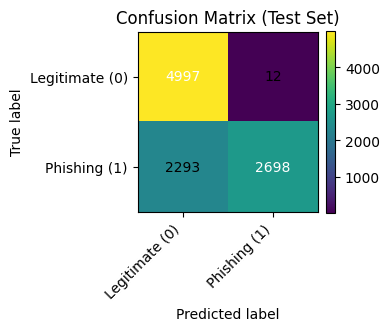

In [ ]:

fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (Test Set)")
plt.colorbar(im, fraction=0.046, pad=0.04)

tick_marks = np.arange(2)
ax.set_xticks(tick_marks)
ax.set_yticks(tick_marks)
ax.set_xticklabels(["Legitimate (0)", "Phishing (1)"], rotation=45, ha="right")
ax.set_yticklabels(["Legitimate (0)", "Phishing (1)"])
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")

thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i, format(cm[i, j], "d"),
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black"
        )

plt.tight_layout()
plt.show()

This block visualizes the confusion matrix using matplotlib by creating a heatmap with color intensity representing counts, labeling axes with class names, and overlaying numeric values for each cell with contrasting text colors. Its structure separates figure setup, axis configuration, and cell annotation. The logic ensures clarity in interpreting model performance on legitimate versus phishing classes. Strengths include informative visual output and readable labels. Weaknesses include static figure size and no support for dynamic class numbers beyond two.

In [ ]:
results_df = test_df.copy()
results_df["pred_label"] = all_preds
results_df["prob_legit"] = all_probs[:, 0]
results_df["prob_phish"] = all_probs[:, 1]

output_file = "test_predictions_guardmyinbox.xlsx"
results_df.to_excel(output_file, index=False)
print(f"\n Saved detailed test predictions to {output_file}")

if IN_COLAB:
    files.download(output_file)


 Saved detailed test predictions to test_predictions_guardmyinbox.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

This block generates a duplicate DataFrame for the test set, attaches predicted labels, as well as class probabilities, writes the expanded DataFrame to an Excel file, and enables initiating download in Colab. The format of the code separates within the code the process of preparing data, generating file output, and downloading the output (was not required but made it easier for the code separation). The logic of the code allows for retaining both raw information, predictive model information, and surrounding surveillance capabilities of data for reporting or analysis. Advantages of the code include clear tracking of predictions and probabilities versus its predecessor method. Negatives include a static export name and no handling for writing errors, with the implemented code.